In [8]:
### Import the required libraries
import numpy as np
import matplotlib.pyplot as plt 

import warnings
warnings.simplefilter("ignore")

import tensorflow as tf
import tensorflow.keras as keras
tf.compat.v1.disable_eager_execution()

import os
import sys

import xarray as xr
import xmitgcm
from xmitgcm import open_mdsdataset
import ecco_v4_py as ecco

# Append to sys.path the absolute path to src/XAIRT
path_list = os.path.abspath('').split('/')
path_src_XAIRT = ''
for link in path_list[:-1]:
    path_src_XAIRT = path_src_XAIRT+link+'/'
sys.path.append(path_src_XAIRT+'/src')

# Now import module XAIRT
from XAIRT import *

In [9]:
mainDir  = '/scratch2/pillarh/eccov4r4'
gridDir  = mainDir + '/GRID'
thetaDir = mainDir + '/eccov4r4_nctiles_daily/THETA'

In [35]:
hFacC = ecco.read_llc_to_tiles(gridDir, 'hFacC.data')
YC = ecco.read_llc_to_tiles(gridDir, 'YC.data')
XC = ecco.read_llc_to_tiles(gridDir, 'XC.data')

load_binary_array: loading file /scratch2/pillarh/eccov4r4/GRID/hFacC.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4
load_binary_array: loading file /scratch2/pillarh/eccov4r4/GRID/YC.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4
load_binary_array: loading file /scratch2/pillarh/eccov4r4/GRID/XC.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape 

In [36]:
ds = xr.open_dataset(thetaDir + '/' + '1992/001/THETA_1992_01_01.nc')

ds_grid = xr.Dataset(
    data_vars = dict(
        hFacC = (("tile", "j", "i"), hFacC),
        YC    = (("tile", "j", "i"), YC),
        XC    = (("tile", "j", "i"), XC),
    ),
    coords=dict(
        k = ds['k'].data,
        tile = ds['tile'].data,
        j = ds['j'].data,
        i = ds['i'].data,
    ),
    attrs=dict(description="ECCO v4r4 Grid related fields"),
)


latMask = YC > -20.0
latMask = latMask.astype(float)

da_latMask = xr.DataArray(
    data=latMask,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds['tile'].data,
        j    = ds['j'].data,
        i    = ds['i'].data,
    ),
    attrs=dict(description="Latitude Mask True if > -20"),
)


hFacC_mask = hFacC > 0
hFacC_mask = hFacC_mask.astype(float)

maskFinal = hFacC_mask * latMask

da_hFacC_mask = xr.DataArray(
    data=hFacC_mask,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds['tile'].data,
        j    = ds['j'].data,
        i    = ds['i'].data,
    ),
    attrs=dict(description="hFacC mask 3D True if > 0"),
)

da_maskFinal = xr.DataArray(
    data=maskFinal,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds['tile'].data,
        j    = ds['j'].data,
        i    = ds['i'].data,
    ),
    attrs=dict(description="hFacC mask 2D True if > 0"),
)

ds_grid = ds_grid.assign(latMask = da_latMask, 
                         hFacC_mask = da_hFacC_mask, 
                         maskFinal = da_maskFinal)

Text(0.5, 1.0, 'Masked theta for training')

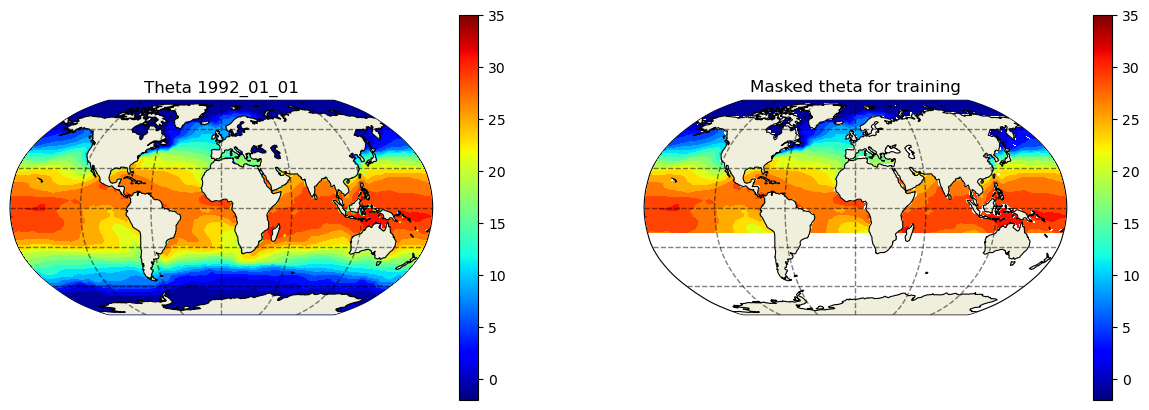

In [37]:
plt.figure(figsize=(15,5))

P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                              ds['THETA'].isel(time = 0, k = 0),
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='jet', cmax = 35,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [1,2,1]);
P[1].set_title("Theta 1992_01_01")

NaNmaskFinal = np.copy(ds_grid['maskFinal'].data)
NaNmaskFinal[NaNmaskFinal == 0] = np.nan

P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                              NaNmaskFinal*ds['THETA'].isel(time = 0, k = 0),
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='jet', cmax = 35,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [1,2,2]);
P[1].set_title("Masked theta for training")

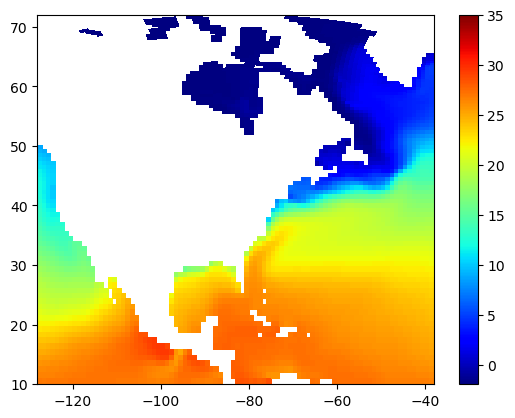

In [56]:
NaNmaskFinal = np.copy(ds_grid['maskFinal'].isel(tile = 10).data)
NaNmaskFinal[NaNmaskFinal == 0] = np.nan
data = NaNmaskFinal*ds['THETA'].isel(time = 0, k = 0, tile = 10)
x = ds_grid['XC'].isel(tile = 10)
y = ds_grid['YC'].isel(tile = 10)
plt.pcolor(x, y, data, cmap = 'jet', vmax = 35)
plt.colorbar()

In [13]:
wetpoints = np.nonzero(ds_grid['maskFinal'].data)
x = ds['THETA'].isel(time = 0, k = 0).data[wetpoints[0],wetpoints[1],wetpoints[2]]

In [14]:
# The full ECCO period (1992/01/01 - 2017/12/31)
years = np.arange(1992,2018,1)
days  = (years%4 == 0) + 365
num_days = np.sum(days)

X = np.zeros((num_days, len(wetpoints[0])), dtype = np.float64)
y = np.zeros((num_days, 1), dtype = np.float64)

In [ ]:
# The netcdf files containing the data are organized with the following directory structure:
# /scratch2/pillarh/eccov4r4/eccov4r4_nctiles_daily/THETA/ ${YEAR} / ${DAY} / THETA_${YEAR}_${MONTH}_${DAY}.nc

day_counter = 0
for i in range(len(years)):
    for j in range(1,days[i]+1): 
        print(f'{years[i]}, {j:03}')
        ds = xr.open_dataset(thetaDir + '/' + f'{years[i]}/{j:03}/THETA_{years[i]}_01_{j:02}.nc')
        X[day_counter] = ds['THETA'].isel(time = 0, k = 0).data[wetpoints[0],wetpoints[1],wetpoints[2]]
        y[day_counter] = 
        day_counter = day_counter + 1

In [ ]:
day_counter

In [ ]:
def quickSetup(X, y, numVars, lrp_methods, lagSteps, baseAnalysis, numAnalysis, **NNkwargs):
    
    result = {}
    
    if lagSteps > 0:
        K = TrainFullyConnectedNN(X[:-lagSteps], y[lagSteps:], **NNkwargs)
        L = TrainLR(X[:-lagSteps], y[lagSteps:], y_ref = 0.0, fit_intercept = False)
    if lagSteps == 0:
        K = TrainFullyConnectedNN(X, y, **NNkwargs)
        L = TrainLR(X, y, y_ref = 0.0, fit_intercept = False)
        
    best_model = K.quickTrain()
    result['cost_predict_NN'] = best_model.predict(X)
    
    regr = L.quickTrain()
    result['cost_predict_LR'] = regr.predict(X)
    
    normalizeDict = {'bool_': True, 'kind': 'MaxAbs'}
    kwargs = {'y_ref': 0.00}

    
    
    for method in lrp_methods:
        
        print(f'Analyze using {method}')
        
        Xplain = XAIR(best_model, method, 'classic', X[baseAnalysis:baseAnalysis+numAnalysis], normalizeDict, **kwargs)
        a, _  = Xplain.quick_analyze()
        perVar = int(a.shape[1]/numVars)
        
        rel = np.zeros((numVars, numAnalysis, ny, nx))
        rel[:,:,:,:] = np.nan
        
        for numvar in range(numVars):
            rel[numvar,:,wetpoints[0],wetpoints[1]] = a[:,numvar*perVar:(numvar+1)*perVar].T
        result[method] = rel
        
    print(f'Analyze using lrp.LR')
    
    XL = XLR(regr, X[baseAnalysis:baseAnalysis+numAnalysis])
    a_LR, _ = XL.quick_analyze()
    perVar = int(a_LR.shape[1]/numVars)
    
    rel_LR = np.zeros((numVars, numAnalysis, ny, nx))
    rel_LR[:,:,:,:] = np.nan

    for numvar in range(numVars):
        rel_LR[numvar,:,wetpoints[0],wetpoints[1]] = a_LR[:,numvar*perVar:(numvar+1)*perVar].T
    result['lrp.LR'] = rel_LR
        
    return result

In [ ]:
LayersTheta = [{'size': thetaSurfWet.shape[1], 'activation': None    , 'use_bias': None},
          {'size': 200                   , 'activation': 'relu'  , 'use_bias': True},
          {'size': 1                    , 'activation': 'linear', 'use_bias': False}]

Losses = [{'kind': 'mse', 'weight': 1.0}]

LRPDict_theta = {}
lagStepsList = [30, 60, 90, 120, 150, 180]

kwargs = {'losses': Losses, 'optim': 'adam', 'metrics': ['mae'],
            'batch_size': 10, 'epochs': 50, 'validation_split': 0.2,
            'filename': 'model', 'dirname': os.path.abspath('')}

for i in range(len(lagStepsList)):
    
    print(f'Lag: {lagStepsList[i]} days, for Theta')
    LRPDict_theta[f'LRP{lagStepsList[i]}'] = quickSetup(thetaSurfWet, cost, numVars = 1, lrp_methods = ['lrp.alpha_1_beta_0', 'lrp.z'],
                                                        lagSteps = lagStepsList[i], baseAnalysis = 0, numAnalysis = 360,
                                                        layers = LayersTheta, **kwargs)

In [ ]:
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots(2,3)
pltX = 0
pltY = 0
fig.suptitle('LRP_a1b0 for theta (NN trained using theta only)', fontsize=16)

for i in range(len(lagStepsList)):
    pltX = int(i/3)
    pltY = int(i%3)
    
    field = np.mean(LRPDict_theta[f'LRP{lagStepsList[i]}']['lrp.alpha_1_beta_0'][0], axis = 0)
    field = field / np.nanmax(np.abs(field))
    
    p = ax[pltX,pltY].contourf(field, vmin = -1, vmax = 1, levels = 100, cmap = 'RdBu_r')
    ax[pltX,pltY].scatter([58],[32], color = 'black')
    fig.colorbar(p, ax=ax[pltX,pltY])
    ax[pltX,pltY].set_title(f'Mean annual normalized LRP_a1b0 for time lag: {lagStepsList[i]} ')

In [ ]:
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots(2,3)
pltX = 0
pltY = 0
fig.suptitle('LRP_z for theta (NN trained using theta only)', fontsize=16)

for i in range(len(lagStepsList)):
    pltX = int(i/3)
    pltY = int(i%3)
    
    field = np.mean(LRPDict_theta[f'LRP{lagStepsList[i]}']['lrp.z'][0], axis = 0)
    field = field / np.nanmax(np.abs(field))
    
    p = ax[pltX,pltY].contourf(field, vmin = -1, vmax = 1, levels = 100, cmap = 'RdBu_r')
    ax[pltX,pltY].scatter([58],[32], color = 'black')
    fig.colorbar(p, ax=ax[pltX,pltY])
    ax[pltX,pltY].set_title(f'Mean annual normalized LRP_z for time lag: {lagStepsList[i]} ')

In [ ]:
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots(2,3)
pltX = 0
pltY = 0
fig.suptitle('LRP_LR for theta (NN trained using theta only)', fontsize=16)

for i in range(len(lagStepsList)):
    pltX = int(i/3)
    pltY = int(i%3)
    
    field = np.mean(LRPDict_theta[f'LRP{lagStepsList[i]}']['lrp.LR'][0], axis = 0)
    field = field / np.nanmax(np.abs(field))
    
    p = ax[pltX,pltY].contourf(field, vmin = -1, vmax = 1, levels = 100, cmap = 'RdBu_r')
    ax[pltX,pltY].scatter([58],[32], color = 'black')
    fig.colorbar(p, ax=ax[pltX,pltY])
    ax[pltX,pltY].set_title(f'Mean annual normalized LRP_LR for time lag: {lagStepsList[i]} ')